<a href="https://colab.research.google.com/github/Davis-Tony/DS-Unit-2-Linear-Models/blob/master/TonyDavis_LS_DS_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [3]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [4]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [5]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [6]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [8]:
#Pulling up dataframe
df.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


### Train/Validate/Test Split

In [9]:
#Checking datatypes
df.dtypes

Burrito            object
Date               object
Yelp              float64
Google            float64
Chips              object
Cost              float64
Hunger            float64
Mass (g)          float64
Density (g/mL)    float64
Length            float64
Circum            float64
Volume            float64
Tortilla          float64
Temp              float64
Meat              float64
Fillings          float64
Meat:filling      float64
Uniformity        float64
Salsa             float64
Synergy           float64
Wrap              float64
Unreliable         object
NonSD              object
Beef               object
Pico               object
Guac               object
Cheese             object
Fries              object
Sour cream         object
Pork               object
Chicken            object
Shrimp             object
Fish               object
Rice               object
Beans              object
Lettuce            object
Tomato             object
Bell peper         object
Carrots     

In [10]:
#Converting date of review to datetime type
df['Date'] = pd.to_datetime(df['Date'])

In [12]:
#Rechecking datatypes
df.dtypes

Burrito                   object
Date              datetime64[ns]
Yelp                     float64
Google                   float64
Chips                     object
Cost                     float64
Hunger                   float64
Mass (g)                 float64
Density (g/mL)           float64
Length                   float64
Circum                   float64
Volume                   float64
Tortilla                 float64
Temp                     float64
Meat                     float64
Fillings                 float64
Meat:filling             float64
Uniformity               float64
Salsa                    float64
Synergy                  float64
Wrap                     float64
Unreliable                object
NonSD                     object
Beef                      object
Pico                      object
Guac                      object
Cheese                    object
Fries                     object
Sour cream                object
Pork                      object
Chicken   

In [13]:
#Reviewing head of df
df.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,2016-01-18,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,2016-01-24,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,2016-01-24,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,2016-01-24,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,2016-01-27,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [17]:
#Splitting df into train, validating, and test dataframes

train = df[df['Date'] < '2017-01-01']
val = df[(df['Date'] > '2016-12-31') & (df['Date'] < '2018-01-01')]
test = df[df['Date'] > '2017-12-31']

In [16]:
#Checking shape of df for reference
df.shape

(421, 59)

In [18]:
#Checking counts

train.shape, val.shape, test.shape

((298, 59), (85, 59), (38, 59))

### Baselines for Classification

Can we predict whether a burrito will be great?

In [20]:
#How many burritos from the dataset actually qualify as 'Great'?
target = 'Great'
y_train = train[target]
y_train.value_counts(normalize=True)

False    0.590604
True     0.409396
Name: Great, dtype: float64

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


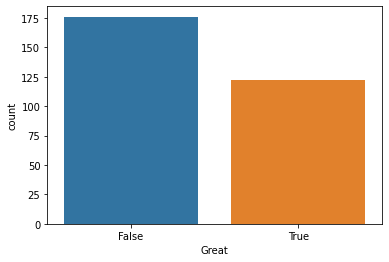

In [21]:
# display that as a graphic.
import seaborn as sns
sns.countplot(y_train);

In [22]:
#Finding majority class for every prediction
majority_class = y_train.mode()

In [23]:
# create a list of zeroes as long as our training dataset.
y_pred = [majority_class] * len(y_train)

What is the baseline accuracy if we guessed the majority class for every prediction?

In [24]:
from sklearn.metrics import accuracy_score

In [25]:
# Training accuracy of majority class baseline = 
# frequency of majority class (aka base rate)
accuracy_score(y_train, y_pred)

0.5906040268456376

###Use scikit-learn for logistic regression

In [26]:
from sklearn.linear_model import LogisticRegression

In [30]:
#Recall the dataframe
df.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,2016-01-18,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,2016-01-24,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,2016-01-24,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,2016-01-24,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,2016-01-27,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [31]:
df.columns

Index(['Burrito', 'Date', 'Yelp', 'Google', 'Chips', 'Cost', 'Hunger',
       'Mass (g)', 'Density (g/mL)', 'Length', 'Circum', 'Volume', 'Tortilla',
       'Temp', 'Meat', 'Fillings', 'Meat:filling', 'Uniformity', 'Salsa',
       'Synergy', 'Wrap', 'Unreliable', 'NonSD', 'Beef', 'Pico', 'Guac',
       'Cheese', 'Fries', 'Sour cream', 'Pork', 'Chicken', 'Shrimp', 'Fish',
       'Rice', 'Beans', 'Lettuce', 'Tomato', 'Bell peper', 'Carrots',
       'Cabbage', 'Sauce', 'Salsa.1', 'Cilantro', 'Onion', 'Taquito',
       'Pineapple', 'Ham', 'Chile relleno', 'Nopales', 'Lobster', 'Queso',
       'Egg', 'Mushroom', 'Bacon', 'Sushi', 'Avocado', 'Corn', 'Zucchini',
       'Great'],
      dtype='object')

In [36]:
#Beginning Logistic Regression by building training and validation matrices
features = ['Burrito', 'Tortilla', 'Temp', 'Meat', 'Fillings', 'Meat:filling', 'Uniformity',
            'Salsa', 'Synergy', 'Wrap']

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((298, 10), (298,), (85, 10), (85,))

In [37]:
# any missing data?
print(X_train.isnull().sum())
print(X_val.isnull().sum())

Burrito          0
Tortilla         0
Temp            15
Meat            10
Fillings         1
Meat:filling     6
Uniformity       2
Salsa           20
Synergy          2
Wrap             2
dtype: int64
Burrito         0
Tortilla        0
Temp            5
Meat            2
Fillings        1
Meat:filling    2
Uniformity      0
Salsa           2
Synergy         0
Wrap            0
dtype: int64


In [38]:
#Imports to impute missing data
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

In [39]:
# take a look at our features
X_train.head()

,Burrito,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap
0,California,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0
1,California,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0
2,Carnitas,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0
3,Asada,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0
4,California,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0


In [40]:
# looks like we have one categorical variable in there
X_val.head()

,Burrito,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap
301,California,4.0,4.5,4.0,3.5,3.5,5.0,1.5,3.50,4.5
302,Other,4.0,2.0,NaN,4.0,NaN,4.6,4.2,3.75,5.0
303,Other,3.0,4.5,4.1,3.0,3.7,4.0,4.3,4.20,5.0
304,Other,3.5,4.0,4.0,3.0,4.0,4.5,4.0,3.80,4.8
305,Other,2.5,4.5,3.0,2.5,3.0,3.0,2.0,2.00,4.0


In [41]:
# let's convert the categorical variable to dummies using one-hot encoding in our training dataset.
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)

In [42]:
# now we do the same thing for our validation dataset
X_val_encoded = encoder.transform(X_val)

In [43]:
# what do the results look like?
X_train_encoded.head()

,Burrito_California,Burrito_Carnitas,Burrito_Asada,Burrito_Other,Burrito_Surf & Turf,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap
0,1,0,0,0,0,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0
1,1,0,0,0,0,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0
2,0,1,0,0,0,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0
3,0,0,1,0,0,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0
4,1,0,0,0,0,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0


In [44]:
# we also want to impute missing values throughout the dataset.
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_encoded)

In [45]:
# note that, for the validation dataset, we want to use the same mean as the training dataset (so we don't re-fit)
X_val_imputed = imputer.transform(X_val_encoded)

In [46]:
# finally, we want to scale our data so they're all on the same metric.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)

In [47]:
# again, for the validation dataset we don't re-fit the scaler. 
X_val_scaled = scaler.transform(X_val_imputed)

In [48]:
# what do our transformed data look like?
pd.DataFrame(X_val_scaled).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.235080,-0.222027,-0.364801,-0.764922,-0.27534,0.662698,0.822508,5.259498e-01,-0.022447,-2.807903e-02,1.480371,-1.948611,-0.043805,0.469183
1,-0.809664,-0.222027,-0.364801,1.307322,-0.27534,0.662698,-1.768429,-5.204469e-16,0.567531,-4.319242e-16,1.111214,0.934834,0.228594,0.899679
2,-0.809664,-0.222027,-0.364801,1.307322,-0.27534,-0.593162,0.822508,6.431440e-01,-0.612425,1.664423e-01,0.557478,1.041628,0.718913,0.899679
3,-0.809664,-0.222027,-0.364801,1.307322,-0.27534,0.034768,0.304321,5.259498e-01,-0.612425,4.582244e-01,1.018924,0.721245,0.283074,0.727480
4,-0.809664,-0.222027,-0.364801,1.307322,-0.27534,-1.221093,0.822508,-6.459925e-01,-1.202403,-5.143825e-01,-0.365416,-1.414639,-1.678199,0.038686


In [49]:
# we're finally ready to fit out model using the transformed training dataset.
model = LogisticRegressionCV()
model.fit(X_train_scaled, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [50]:
# make predictions
y_pred = model.predict(X_val_scaled)

In [51]:
# there are different two ways to output the model's accuracy.
print('Validation Accuracy', accuracy_score(y_val, y_pred))
print('Validation Accuracy', model.score(X_val_scaled, y_val))

Validation Accuracy 0.8823529411764706
Validation Accuracy 0.8823529411764706


Plotting

In [52]:
# what are the coeffs? what do they mean?
coefficients = pd.DataFrame(model.coef_[0], X_train_encoded.columns, columns=['probabilities'])
print(coefficients)

                     probabilities
Burrito_California        0.135245
Burrito_Carnitas          0.005900
Burrito_Asada            -0.018514
Burrito_Other            -0.079712
Burrito_Surf & Turf      -0.089726
Tortilla                  0.322610
Temp                      0.266459
Meat                      0.603216
Fillings                  0.599650
Meat:filling              0.495888
Uniformity                0.162981
Salsa                     0.269263
Synergy                   0.668379
Wrap                      0.047044


In [57]:
# You can get the odds ratios by taking the exponent of the coeffecients:
import numpy as np
odds_ratios = np.exp(model.coef_)
coefficients['odds_ratios']=odds_ratios[0]
coefficients

Burrito_California                                              0.135245
Burrito_Carnitas                                              0.00589984
Burrito_Asada                                                  -0.018514
Burrito_Other                                                 -0.0797118
Burrito_Surf & Turf                                            -0.089726
Tortilla                                                         0.32261
Temp                                                            0.266459
Meat                                                            0.603216
Fillings                                                         0.59965
Meat:filling                                                    0.495888
Uniformity                                                      0.162981
Salsa                                                           0.269263
Synergy                                                         0.668379
Wrap                                               

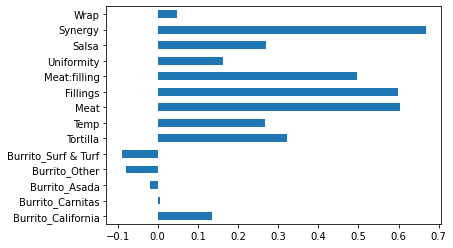

In [60]:
# display the coeffs alphabetically, by name
coefficients.plot.barh();

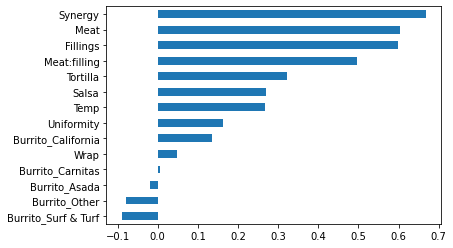

In [59]:
# display the coeffs from least to greatest
coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
coefficients.sort_values().plot.barh();

###Validation Accuracy

In [61]:
print('Validation Accuracy', accuracy_score(y_val, y_pred))
print('Validation Accuracy', model.score(X_val_scaled, y_val))

Validation Accuracy 0.8823529411764706
Validation Accuracy 0.8823529411764706


###Test Accuracy

In [63]:
X_test = test[features]
y_test = test[target]

In [68]:
#One-hot encoding the test data
X_test_encoded = encoder.transform(X_test)

In [69]:
#Imputing missing data
X_test_imputed = imputer.transform(X_test_encoded)

In [70]:
#Scaling data so it's on the same metric
X_test_scaled = scaler.transform(X_test_imputed)

In [72]:
#Make predictions
y_pred2 = model.predict(X_test_scaled)

In [74]:
print('Test Accuracy', accuracy_score(y_test, y_pred2))

Test Accuracy 0.7368421052631579
